<center>
  <img src="./Squarepoint_Capital.png" alt="Squarepoint Capital" title="Squarepoint Capital Logo" width="750"/>
</center>

In [2]:
%config Completer.use_jedi = True
%config Completer.use_jedi = False

In [3]:
import pandas as pd
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns

base_path = "/Users/kennethzhang/Desktop/VolAuction/data"

In [4]:
es_futures = pd.read_csv(base_path + "/es_futures_1m_all.csv")

In [9]:
es_futures

,Datetime,Open,High,Low,Close,Volume,Dividends,Stock Splits,date
0,2025-03-24 00:00:00-04:00,5754.00,5754.00,5752.75,5753.00,0,0.0,0.0,2025-03-24
1,2025-03-24 00:01:00-04:00,5753.00,5753.00,5752.75,5752.75,75,0.0,0.0,2025-03-24
2,2025-03-24 00:02:00-04:00,5753.00,5753.25,5752.75,5753.25,18,0.0,0.0,2025-03-24
3,2025-03-24 00:03:00-04:00,5753.00,5753.00,5752.50,5752.50,85,0.0,0.0,2025-03-24
4,2025-03-24 00:04:00-04:00,5752.50,5753.25,5752.50,5753.00,62,0.0,0.0,2025-03-24
...,...,...,...,...,...,...,...,...,...
7811,2025-03-31 16:55:00-04:00,5645.75,5646.00,5645.00,5645.25,632,0.0,0.0,2025-03-31
7812,2025-03-31 16:56:00-04:00,5645.25,5645.75,5644.25,5644.50,420,0.0,0.0,2025-03-31
7813,2025-03-31 16:57:00-04:00,5644.50,5645.00,5644.00,5644.50,344,0.0,0.0,2025-03-31
7814,2025-03-31 16:58:00-04:00,5644.50,5644.75,5644.00,5644.25,212,0.0,0.0,2025-03-31


In [10]:
es_futures["Datetime"] = pd.to_datetime(es_futures["Datetime"])
es_futures = es_futures.set_index("Datetime").sort_index()

In [12]:
es_5min = es_futures.resample('5T').agg({
    'Open': 'first',
    'High': 'max',
    'Low': 'min',
    'Close': 'last',
    'Volume': 'sum'
}).dropna()

/var/folders/bc/0sv4l9h92yb5pz7_7vm4gh900000gn/T/ipykernel_8665/1364781490.py:1: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  es_5min = es_futures.resample('5T').agg({


In [13]:
es_5min

,Open,High,Low,Close,Volume
Datetime,,,,,
2025-03-24 00:00:00-04:00,5754.00,5754.00,5752.50,5753.00,240
2025-03-24 00:05:00-04:00,5753.00,5753.50,5752.75,5753.00,155
2025-03-24 00:10:00-04:00,5752.75,5753.25,5752.25,5752.50,238
2025-03-24 00:15:00-04:00,5752.50,5753.75,5752.50,5753.75,152
2025-03-24 00:20:00-04:00,5753.50,5754.00,5753.00,5753.00,153
...,...,...,...,...,...
2025-03-31 16:35:00-04:00,5645.25,5646.25,5644.75,5646.25,1002
2025-03-31 16:40:00-04:00,5646.00,5647.50,5645.00,5647.25,1208
2025-03-31 16:45:00-04:00,5647.00,5647.25,5645.00,5646.00,1481


In [27]:
def realized_vol(df):
    log_ret = np.log(df['Close'] / df['Close'].shift(1))
    return log_ret.rolling(window=5).std() * np.sqrt(390 / 5)

def parkinson_vol(df: pd.DataFrame):
    range_term = np.log(df['High'] / df['Low']) ** 2
    return np.sqrt((1 / (4 * np.log(2))) * range_term.rolling(window=1).mean()) * np.sqrt(390 / 5)

def garman_klass_vol(df):
    log_open_close = np.log(df['Close'] / df['Open']) ** 2
    log_high_low = np.log(df['High'] / df['Low']) ** 2
    estimator = 0.5 * log_high_low - (2 * np.log(2) - 1) * log_open_close
    return np.sqrt(estimator.rolling(window=1).mean()) * np.sqrt(390 / 5)

def yang_zhang_vol(df, window=5):
    df = df.copy()
    df['prev_close'] = df['Close'].shift(1)
    
    o = np.log(df['Open'] / df['prev_close'])
    c = np.log(df['Close'] / df['Open'])
    r = np.log(df['Close'] / df['prev_close'])

    sigma_o2 = o.rolling(window=window).var()
    sigma_c2 = c.rolling(window=window).var()
    sigma_rs = (np.log(df['High'] / df['Low']) ** 2).rolling(window=window).mean()

    k = 0.34 / (1.34 + (1 + 1))
    yz = sigma_o2 + k * sigma_rs + (1 - k) * sigma_c2
    return np.sqrt(yz) * np.sqrt(390 / 5)


In [28]:
es_5min['RealizedVol'] = realized_vol(es_5min)
es_5min['ParkinsonVol'] = parkinson_vol(es_5min)
es_5min['GarmanKlassVol'] = garman_klass_vol(es_5min)
es_5min['YangZhangVol'] = yang_zhang_vol(es_5min)

In [29]:
es_5min

,Open,High,Low,Close,Volume,RealizedVol,ParkinsonVol,GarmanKlassVol,YangZhangVol
Datetime,,,,,,,,,
2025-03-24 00:00:00-04:00,5754.00,5754.00,5752.50,5753.00,240,NaN,0.001383,0.001319,NaN
2025-03-24 00:05:00-04:00,5753.00,5753.50,5752.75,5753.00,155,NaN,0.000691,0.000814,NaN
2025-03-24 00:10:00-04:00,5752.75,5753.25,5752.25,5752.50,238,NaN,0.000922,0.001059,NaN
2025-03-24 00:15:00-04:00,5752.50,5753.75,5752.50,5753.75,152,NaN,0.001152,0.000647,NaN
2025-03-24 00:20:00-04:00,5753.50,5754.00,5753.00,5753.00,153,NaN,0.000922,0.000975,NaN
...,...,...,...,...,...,...,...,...,...
2025-03-31 16:35:00-04:00,5645.25,5646.25,5644.75,5646.25,1002,0.002420,0.001409,0.001345,0.002540
2025-03-31 16:40:00-04:00,5646.00,5647.50,5645.00,5647.25,1208,0.001847,0.002348,0.002484,0.002058
2025-03-31 16:45:00-04:00,5647.00,5647.25,5645.00,5646.00,1481,0.001736,0.002114,0.002291,0.001936


In [80]:
es_5min.to_csv("/Users/kennethzhang/Desktop/VolAuction/data/es_5min.csv")

In [34]:
def plot_intraday_vol(df, date_str):
    day_data = df[df.index.date == pd.to_datetime(date_str).date()]
    plt.figure(figsize=(14, 6))
    plt.plot(day_data.index, day_data['RealizedVol'], label='Realized', linewidth=1.5)
    plt.plot(day_data.index, day_data['ParkinsonVol'], label='Parkinson')
    plt.plot(day_data.index, day_data['GarmanKlassVol'], label='Garman-Klass')
    plt.plot(day_data.index, day_data['YangZhangVol'], label='Yang-Zhang')
    plt.title(f"5-Min Volatility Estimates on {date_str}")
    plt.xlabel("Time")
    plt.ylabel("Volatility (Annualized)")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

In [40]:
print("Start Date: ", min(es_futures["date"]))
print("End Date: ", max(es_futures["date"]))

Start Date:  2025-03-24
End Date:  2025-03-31


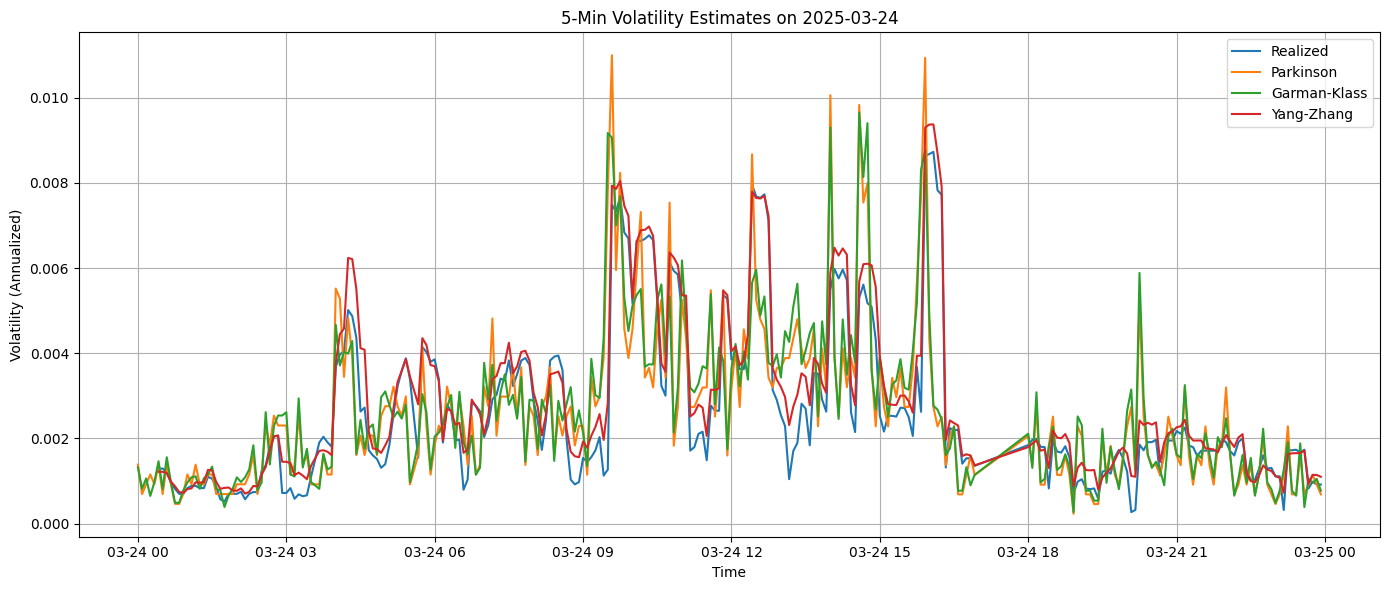

In [41]:
plot_intraday_vol(es_5min, "2025-03-24")

In [44]:
es_futures

,Open,High,Low,Close,Volume,Dividends,Stock Splits,date
Datetime,,,,,,,,
2025-03-24 00:00:00-04:00,5754.00,5754.00,5752.75,5753.00,0,0.0,0.0,2025-03-24
2025-03-24 00:01:00-04:00,5753.00,5753.00,5752.75,5752.75,75,0.0,0.0,2025-03-24
2025-03-24 00:02:00-04:00,5753.00,5753.25,5752.75,5753.25,18,0.0,0.0,2025-03-24
2025-03-24 00:03:00-04:00,5753.00,5753.00,5752.50,5752.50,85,0.0,0.0,2025-03-24
2025-03-24 00:04:00-04:00,5752.50,5753.25,5752.50,5753.00,62,0.0,0.0,2025-03-24
...,...,...,...,...,...,...,...,...
2025-03-31 16:55:00-04:00,5645.75,5646.00,5645.00,5645.25,632,0.0,0.0,2025-03-31
2025-03-31 16:56:00-04:00,5645.25,5645.75,5644.25,5644.50,420,0.0,0.0,2025-03-31
2025-03-31 16:57:00-04:00,5644.50,5645.00,5644.00,5644.50,344,0.0,0.0,2025-03-31


In [61]:
def realized_vol(df, w=5):
    r = np.log(df['Close'] / df['Close'].shift(1))
    return r.rolling(w).std() * np.sqrt(390 / w)

def parkinson_vol(df, w=5):
    hl = np.log(df['High'] / df['Low']) ** 2
    return np.sqrt((1 / (4 * np.log(2))) * hl.rolling(w).mean()) * np.sqrt(390 / w)

def garman_klass_vol(df, w=5):
    oc = np.log(df['Close'] / df['Open']) ** 2
    hl = np.log(df['High'] / df['Low']) ** 2
    return np.sqrt((0.5 * hl - (2 * np.log(2) - 1) * oc).rolling(w).mean()) * np.sqrt(390 / w)

def yang_zhang_vol(df, w=5):
    df = df.copy()
    df['prev_close'] = df['Close'].shift(1)
    o = np.log(df['Open'] / df['prev_close'])
    c = np.log(df['Close'] / df['Open'])
    rs = np.log(df['High'] / df['Low']) ** 2
    k = 0.34 / (1.34 + (w + 1) / (w - 1))
    return np.sqrt(o.rolling(w).var() + k * rs.rolling(w).mean() + (1 - k) * c.rolling(w).var()) * np.sqrt(390 / w)

summary_stats = []

for date in np.unique(es_futures['date']):
    daily_df = es_futures[es_futures['date'] == date]
    es_5min = daily_df.resample('5T').agg({
        'Open': 'first',
        'High': 'max',
        'Low': 'min',
        'Close': 'last',
        'Volume': 'sum'
    }).dropna()

    rv = realized_vol(es_5min)
    pv = parkinson_vol(es_5min)
    gv = garman_klass_vol(es_5min)
    yz = yang_zhang_vol(es_5min)

    summary_stats.append({
        'date': date,
        'Realized_Mean': rv.mean(),
        'Parkinson_Mean': pv.mean(),
        'GarmanKlass_Mean': gv.mean(),
        'YangZhang_Mean': yz.mean(),
        'Realized_Std': rv.std(),
        'Parkinson_Std': pv.std(),
        'GarmanKlass_Std': gv.std(),
        'YangZhang_Std': yz.std(),
        'Realized_Range': rv.max() - rv.min(),
        'Parkinson_Range': pv.max() - pv.min(),
        'GarmanKlass_Range': gv.max() - gv.min(),
        'YangZhang_Range': yz.max() - yz.min(),
    })

/var/folders/bc/0sv4l9h92yb5pz7_7vm4gh900000gn/T/ipykernel_8665/3879607787.py:27: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  es_5min = daily_df.resample('5T').agg({
/var/folders/bc/0sv4l9h92yb5pz7_7vm4gh900000gn/T/ipykernel_8665/3879607787.py:27: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  es_5min = daily_df.resample('5T').agg({
/var/folders/bc/0sv4l9h92yb5pz7_7vm4gh900000gn/T/ipykernel_8665/3879607787.py:27: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  es_5min = daily_df.resample('5T').agg({
/var/folders/bc/0sv4l9h92yb5pz7_7vm4gh900000gn/T/ipykernel_8665/3879607787.py:27: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  es_5min = daily_df.resample('5T').agg({
/var/folders/bc/0sv4l9h92yb5pz7_7vm4gh900000gn/T/ipykernel_8665/3879607787.py:27: FutureWarning: 'T' is 

In [62]:
summary_df = pd.DataFrame(summary_stats)

In [63]:
summary_df

,date,Realized_Mean,Parkinson_Mean,GarmanKlass_Mean,YangZhang_Mean,Realized_Std,Parkinson_Std,GarmanKlass_Std,YangZhang_Std,Realized_Range,Parkinson_Range,GarmanKlass_Range,YangZhang_Range
0,2025-03-24,0.002622,0.002769,0.002803,0.002969,0.001898,0.001606,0.001585,0.001968,0.008459,0.007130,0.007067,0.008700
1,2025-03-25,0.002194,0.002524,0.002609,0.002538,0.001396,0.001570,0.001665,0.001563,0.007247,0.007371,0.007964,0.007946
2,2025-03-26,0.003277,0.003613,0.003690,0.003871,0.002221,0.002256,0.002340,0.002785,0.010076,0.009103,0.009404,0.015732
3,2025-03-27,0.004363,0.004390,0.004349,0.004869,0.002988,0.002669,0.002625,0.003149,0.014888,0.011065,0.010502,0.015239
4,2025-03-28,0.005109,0.005327,0.005326,0.005715,0.002860,0.002753,0.002724,0.003014,0.011847,0.011636,0.011025,0.012590
5,2025-03-30,0.003558,0.003552,0.003529,0.003874,0.001506,0.001338,0.001447,0.001490,0.006843,0.007549,0.008742,0.006428
6,2025-03-31,0.007259,0.006952,0.006851,0.007923,0.004727,0.003775,0.003646,0.004822,0.019853,0.015166,0.016834,0.020016


In [64]:
melted_mean = summary_df.melt(id_vars='date', 
                              value_vars=['Realized_Mean', 'Parkinson_Mean', 'GarmanKlass_Mean', 'YangZhang_Mean'], 
                              var_name='Estimator', value_name='MeanVol')
melted_std = summary_df.melt(id_vars='date', 
                             value_vars=['Realized_Std', 'Parkinson_Std', 'GarmanKlass_Std', 'YangZhang_Std'], 
                             var_name='Estimator', value_name='StdVol')
melted_range = summary_df.melt(id_vars='date', 
                               value_vars=['Realized_Range', 'Parkinson_Range', 'GarmanKlass_Range', 'YangZhang_Range'], 
                               var_name='Estimator', value_name='RangeVol')

In [65]:
melted_mean['Estimator'] = melted_mean['Estimator'].str.replace('_Mean', '')
melted_std['Estimator'] = melted_std['Estimator'].str.replace('_Std', '')
melted_range['Estimator'] = melted_range['Estimator'].str.replace('_Range', '')

/var/folders/bc/0sv4l9h92yb5pz7_7vm4gh900000gn/T/ipykernel_8665/1164914996.py:2: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar='sd'` for the same effect.

  sns.barplot(data=melted_mean, x='Estimator', y='MeanVol', ci='sd')


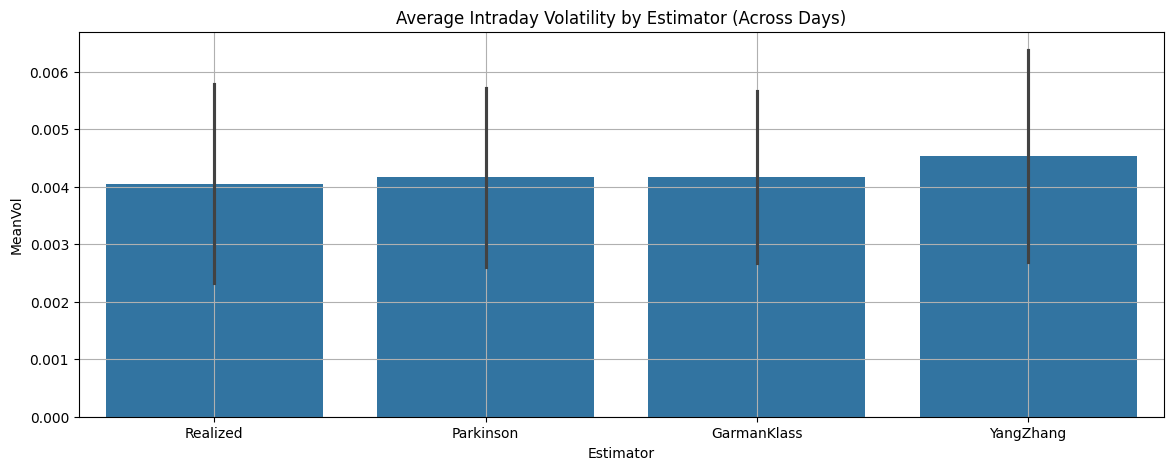

/var/folders/bc/0sv4l9h92yb5pz7_7vm4gh900000gn/T/ipykernel_8665/1164914996.py:8: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar='sd'` for the same effect.

  sns.barplot(data=melted_std, x='Estimator', y='StdVol', ci='sd')


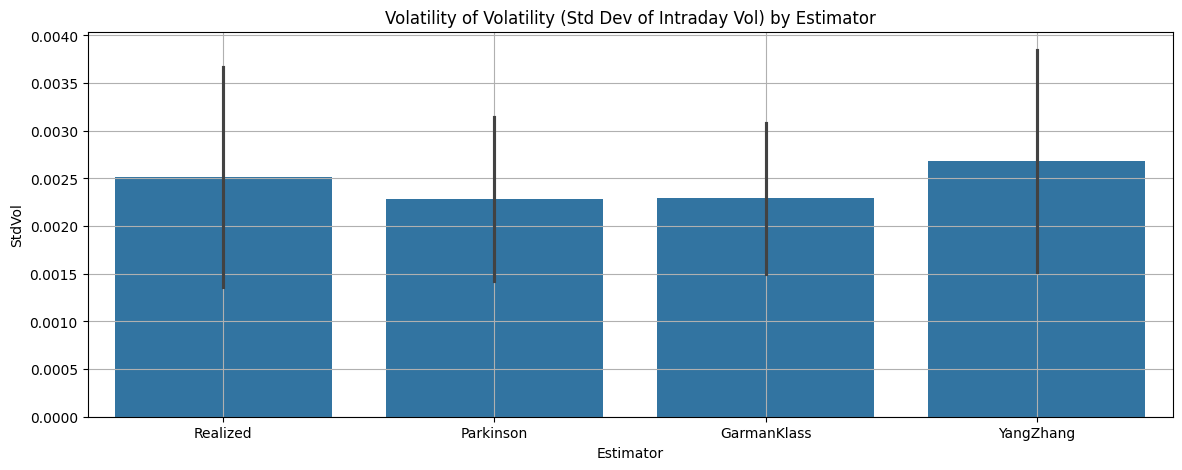

/var/folders/bc/0sv4l9h92yb5pz7_7vm4gh900000gn/T/ipykernel_8665/1164914996.py:14: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar='sd'` for the same effect.

  sns.barplot(data=melted_range, x='Estimator', y='RangeVol', ci='sd')


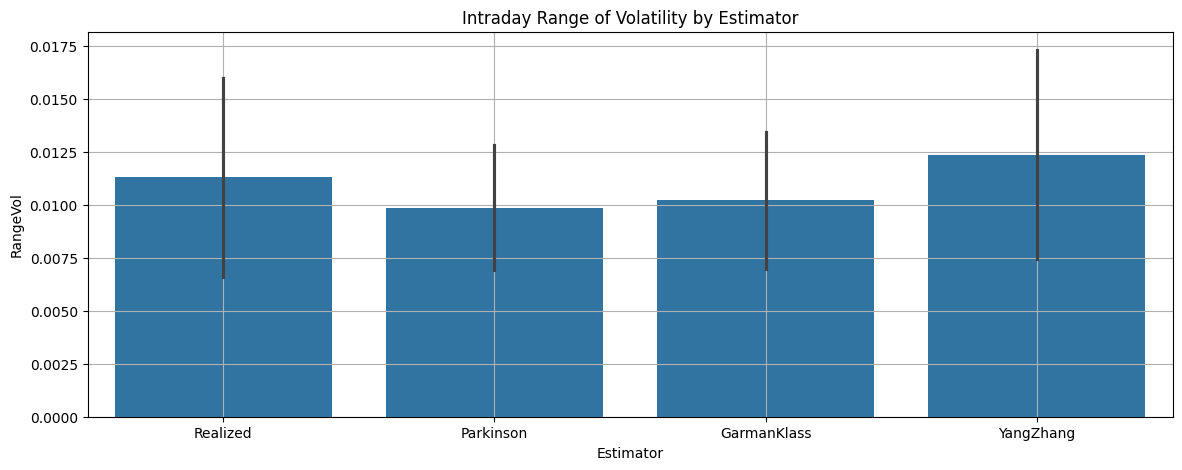

In [66]:
plt.figure(figsize=(14, 5))
sns.barplot(data=melted_mean, x='Estimator', y='MeanVol', ci='sd')
plt.title("Average Intraday Volatility by Estimator (Across Days)")
plt.grid(True)
plt.show()

plt.figure(figsize=(14, 5))
sns.barplot(data=melted_std, x='Estimator', y='StdVol', ci='sd')
plt.title("Volatility of Volatility (Std Dev of Intraday Vol) by Estimator")
plt.grid(True)
plt.show()

plt.figure(figsize=(14, 5))
sns.barplot(data=melted_range, x='Estimator', y='RangeVol', ci='sd')
plt.title("Intraday Range of Volatility by Estimator")
plt.grid(True)
plt.show()

In [73]:
def analyze_vol_dislocation(estimator_func, estimator_name, es_futures_df, window=5):
    tz = es_futures_df.index.tz
    if tz is None:
        from pytz import timezone
        tz = timezone("US/Eastern")

    results = []

    for date in np.unique(es_futures_df['date']):
        daily_df = es_futures_df[es_futures_df['date'] == date]
        es_5min = daily_df.resample('5T').agg({
            'Open': 'first',
            'High': 'max',
            'Low': 'min',
            'Close': 'last',
            'Volume': 'sum'
        }).dropna()

        est_series = estimator_func(es_5min, window)
        naive_time = pd.Timestamp(f"{date} 09:30:00")
        auction_time = naive_time.tz_localize(tz) if naive_time.tzinfo is None else naive_time.tz_convert(tz)

        if auction_time in est_series.index:
            model_iv = est_series.loc[auction_time]
            simulated_iv = model_iv + np.random.normal(scale=0.001)
            results.append({
                'date': pd.to_datetime(date),
                'AuctionIV': simulated_iv,
                estimator_name: model_iv,
                'VolEdge': simulated_iv - model_iv
            })

    return pd.DataFrame(results)

In [74]:
realized_results = analyze_vol_dislocation(realized_vol, "RealizedIV", es_futures)
parkinson_results = analyze_vol_dislocation(parkinson_vol, "ParkinsonIV", es_futures)
garman_klass_results = analyze_vol_dislocation(garman_klass_vol, "GarmanKlassIV", es_futures)
yang_zhang_results = analyze_vol_dislocation(yang_zhang_vol, "YangZhangIV", es_futures)

/var/folders/bc/0sv4l9h92yb5pz7_7vm4gh900000gn/T/ipykernel_8665/924654104.py:11: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  es_5min = daily_df.resample('5T').agg({
/var/folders/bc/0sv4l9h92yb5pz7_7vm4gh900000gn/T/ipykernel_8665/924654104.py:11: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  es_5min = daily_df.resample('5T').agg({
/var/folders/bc/0sv4l9h92yb5pz7_7vm4gh900000gn/T/ipykernel_8665/924654104.py:11: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  es_5min = daily_df.resample('5T').agg({
/var/folders/bc/0sv4l9h92yb5pz7_7vm4gh900000gn/T/ipykernel_8665/924654104.py:11: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  es_5min = daily_df.resample('5T').agg({
/var/folders/bc/0sv4l9h92yb5pz7_7vm4gh900000gn/T/ipykernel_8665/924654104.py:11: FutureWarning: 'T' is depre

In [75]:
all_results = realized_results[['date', 'AuctionIV', 'RealizedIV', 'VolEdge']].rename(columns={'VolEdge': 'RealizedEdge'})
all_results = all_results.merge(parkinson_results[['date', 'ParkinsonIV', 'VolEdge']].rename(columns={'VolEdge': 'ParkinsonEdge'}), on='date')
all_results = all_results.merge(garman_klass_results[['date', 'GarmanKlassIV', 'VolEdge']].rename(columns={'VolEdge': 'GarmanKlassEdge'}), on='date')
all_results = all_results.merge(yang_zhang_results[['date', 'YangZhangIV', 'VolEdge']].rename(columns={'VolEdge': 'YangZhangEdge'}), on='date')

In [79]:
all_results.to_csv("/Users/kennethzhang/Desktop/VolAuction/data/auction_vol_results.csv", index=False)

In [76]:
all_results

,date,AuctionIV,RealizedIV,RealizedEdge,ParkinsonIV,ParkinsonEdge,GarmanKlassIV,GarmanKlassEdge,YangZhangIV,YangZhangEdge
0,2025-03-24,0.001226,0.001266,-0.000040,0.004567,-0.002097,0.005213,0.001530,0.003003,-0.000659
1,2025-03-25,0.004460,0.004305,0.000155,0.004583,0.001359,0.004559,0.001097,0.005087,-0.001121
2,2025-03-26,0.003159,0.002719,0.000440,0.004769,0.000521,0.005135,-0.000658,0.003712,0.001997
3,2025-03-27,0.004910,0.005192,-0.000281,0.007418,0.000349,0.007528,0.000985,0.006511,-0.000477
4,2025-03-28,0.010013,0.009265,0.000748,0.009203,0.000302,0.009521,0.001204,0.010166,-0.000788
5,2025-03-31,0.005119,0.006113,-0.000994,0.010749,0.000753,0.011397,0.000159,0.008284,0.000803


/var/folders/bc/0sv4l9h92yb5pz7_7vm4gh900000gn/T/ipykernel_8665/2599883100.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='date', y=edge_col, data=all_results_df, palette='coolwarm')


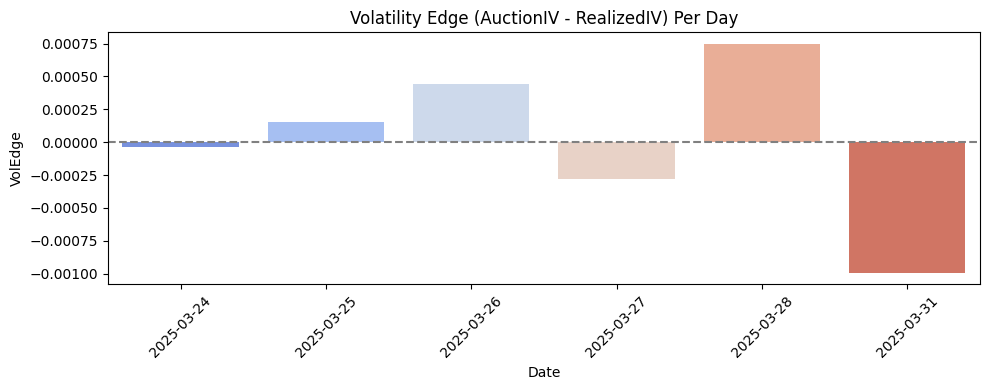

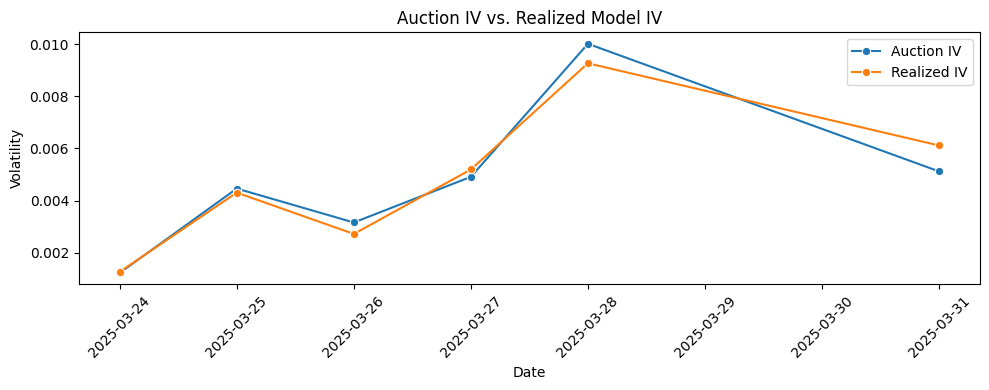

/var/folders/bc/0sv4l9h92yb5pz7_7vm4gh900000gn/T/ipykernel_8665/2599883100.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='date', y=edge_col, data=all_results_df, palette='coolwarm')


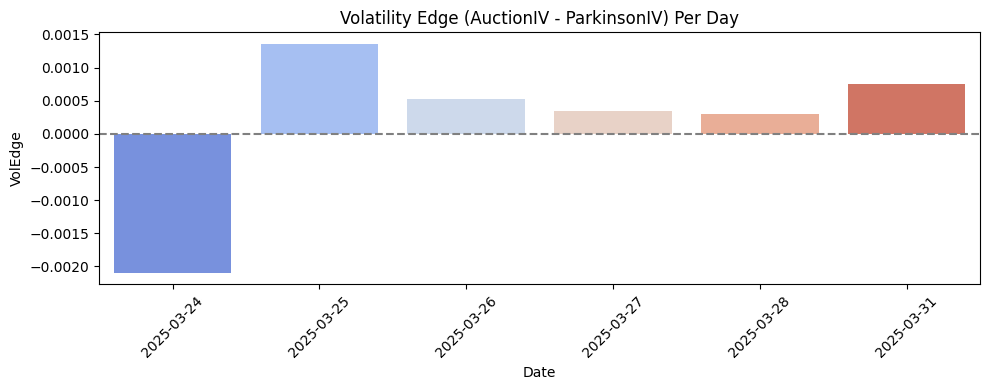

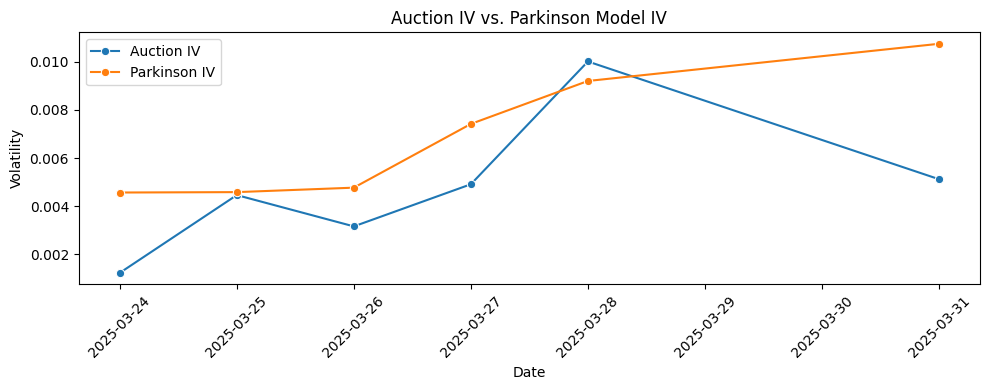

/var/folders/bc/0sv4l9h92yb5pz7_7vm4gh900000gn/T/ipykernel_8665/2599883100.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='date', y=edge_col, data=all_results_df, palette='coolwarm')


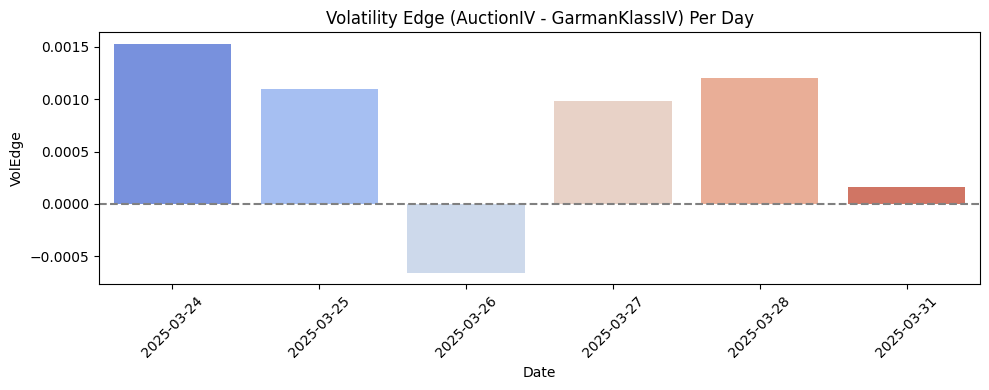

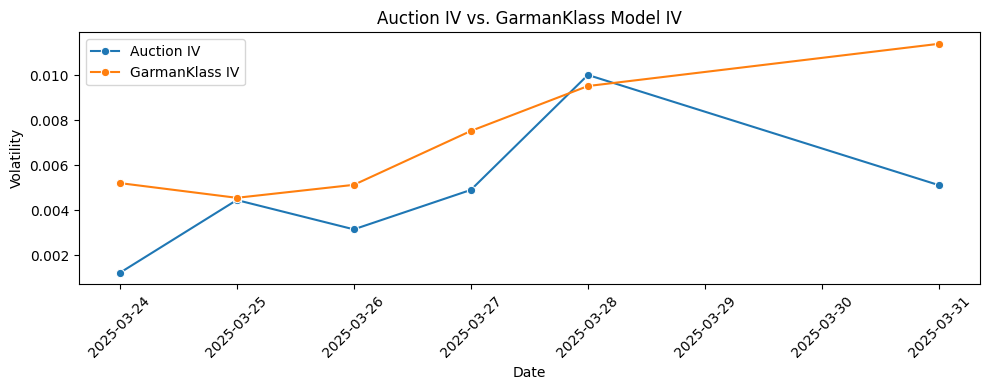

/var/folders/bc/0sv4l9h92yb5pz7_7vm4gh900000gn/T/ipykernel_8665/2599883100.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='date', y=edge_col, data=all_results_df, palette='coolwarm')


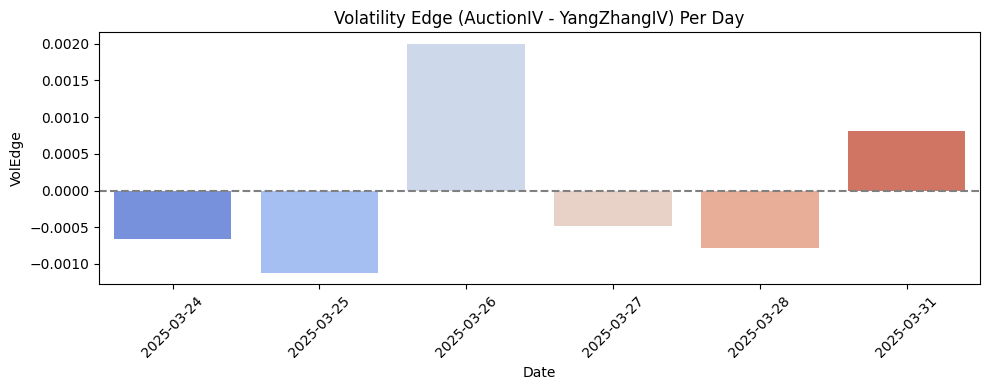

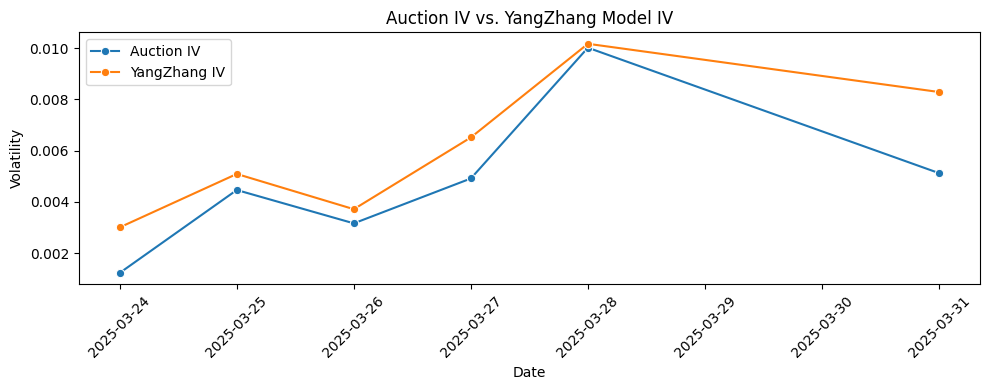

In [77]:
def plot_vol_dislocation(all_results_df):
    estimators = ["Realized", "Parkinson", "GarmanKlass", "YangZhang"]
    
    for estimator in estimators:
        iv_col = f"{estimator}IV"
        edge_col = f"{estimator}Edge"

        plt.figure(figsize=(10, 4))
        sns.barplot(x='date', y=edge_col, data=all_results_df, palette='coolwarm')
        plt.axhline(0, color='gray', linestyle='--')
        plt.title(f"Volatility Edge (AuctionIV - {estimator}IV) Per Day")
        plt.xlabel("Date")
        plt.ylabel("VolEdge")
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.show()

        plt.figure(figsize=(10, 4))
        sns.lineplot(x='date', y='AuctionIV', data=all_results_df, marker='o', label='Auction IV')
        sns.lineplot(x='date', y=iv_col, data=all_results_df, marker='o', label=f'{estimator} IV')
        plt.title(f"Auction IV vs. {estimator} Model IV")
        plt.xlabel("Date")
        plt.ylabel("Volatility")
        plt.xticks(rotation=45)
        plt.legend()
        plt.tight_layout()
        plt.show()

plot_vol_dislocation(all_results)